# Harvest: The Serendipity Machine
___

### Data & Project Overview

As I got involved in Data Science, I have the privilege of many a serendipity. Some were small ... helping me overcome a minor issue. Others had massive impact ... a senior Data Scientist agreed to help mentor me my first year in the field! As I get busier, I don't want these serendipities to stop. Enter Harvest. 

Harvest is a recommendor for 1. I personally labelled thousands of tweets for harvest to teach it my preferences. Most recommendor systems are intended to have consumers spend the most time or money on a given site. Harvest instead just tries to understand my preferences & increase the quality serendipities in my life.

Columns:
* tweet - A data science related tweet, tweeted in spring 2021
* Prefer - I personally labeled. If 1, then likely to lead to a serendipity. 0 otherwise.


In [3]:
!pip install bs4

     |████████████████████████████████| 115 kB 709 kB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=5b9e4a47c86d0a51d2a33cd545e2d1d5d1fb6d3a25a58baf849a5a02b2e5fe07
  Stored in directory: /Users/ammarkhan/Library/Caches/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4


In [5]:
!pip install typing_extensions

In [6]:
# Key modules
# Import key packages
import pandas as pd
pd.set_option('display.max_colwidth', -1) #To display entire text content of a column
pd.set_option('display.max_columns', None) # To display all columns
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Import twint API package
import twint

# To handle runtime errors
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore')

<ipython-input-6-b04b7e6c3be1>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) #To display entire text content of a column


## 0. Load in Data

Re-running was taking too long, so pasted snapshot of previous run below.

In [ ]:
# Loading in Data Science related tweets 
c = twint.Config()

# Set conditions
c.Search = 'data science'
c.Search = 'datascience'
c.Pandas = True
c.Since = '2021-05-01'
c.Until = '2021-05-07'

# Search
twint.run.Search(c)

# Store result as df
ds_tweets = twint.storage.panda.Tweets_df

In [ ]:
# Let's filter by language
ds_tweets = ds_tweets[ds_tweets['language'] == 'en']

In [ ]:
ds_focus = ds_tweets[['tweet','hashtags','photos']]

In [ ]:
ds_focus_1000 = ds_focus[1000:2000]
ds_focus_2000 = ds_focus[2000:3000]

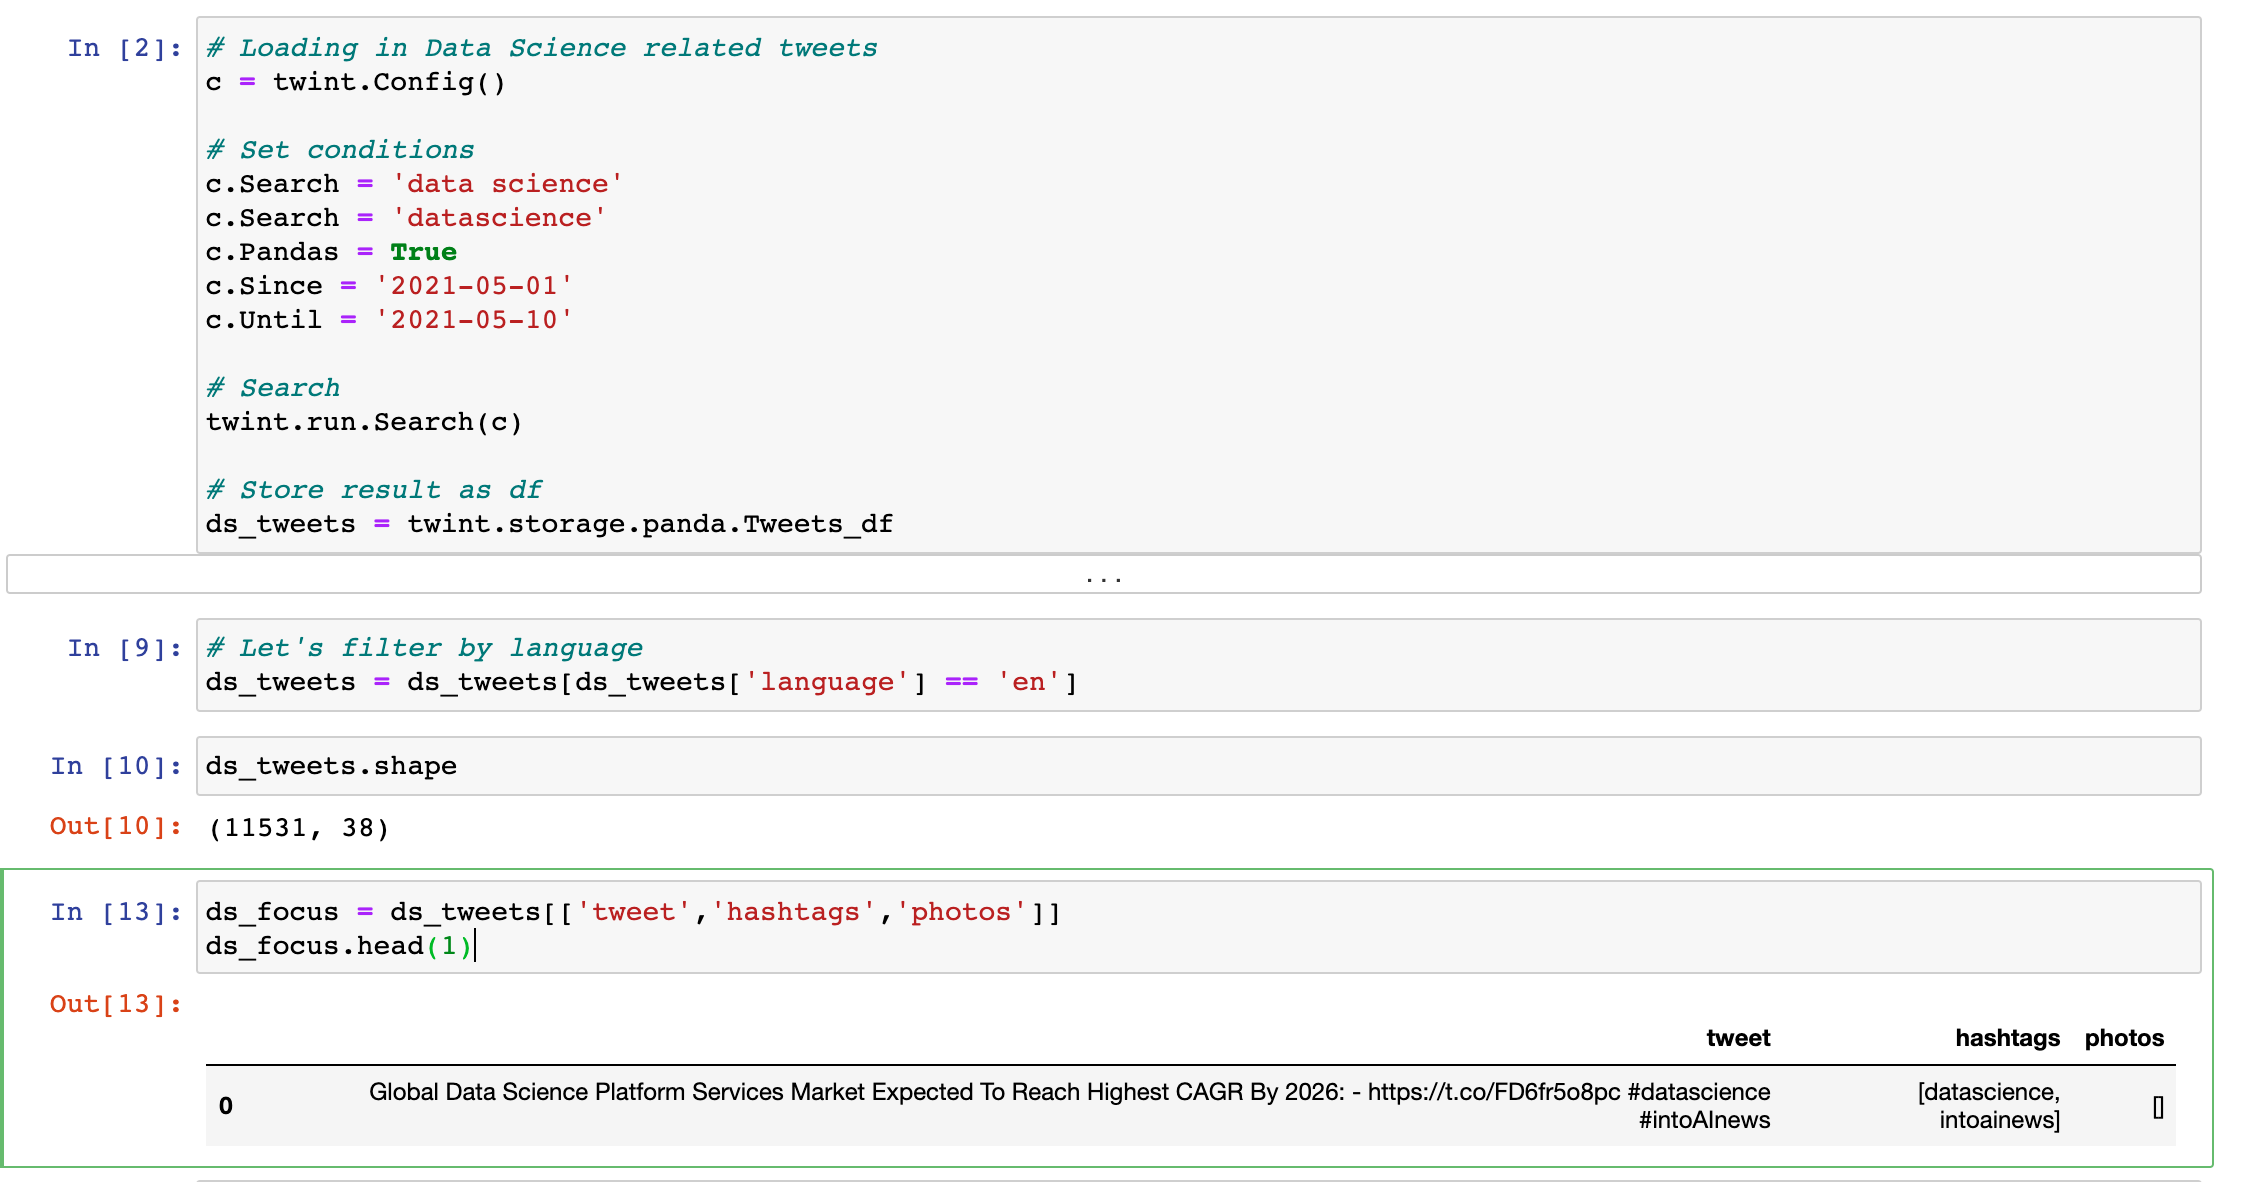

### 7 rows below left un-run to prevent overwrite.

In [ ]:
# Downloading data to label
ds_focus_1000.to_csv('ds_focus_1000.csv')
ds_focus_2000.to_csv('ds_focus_2000.csv')

In [ ]:
# Re-uploading post labeling
tweets_1k = pd.read_csv('DataScience Pivot/Tweets_1000_labeled.csv', index_col=0)
tweets_2k = pd.read_csv('DataScience Pivot/ds_2k_labeled.csv', index_col=0)

In [ ]:
# Let us combine our dfs 
cb_tweets = pd.concat([tweets_1k,tweets_2k], axis=0)

In [ ]:
# Remove duplicates
cb_tweets['tweet'].duplicated().sum()

In [ ]:
# remove duplicates
cb_tweets = cb_tweets[~cb_tweets['tweet'].duplicated()]
cb_tweets.shape

In [ ]:
# For simplicity, let us only keep the tweet & Prefer columns
tweets_ready = cb_tweets[['tweet','Prefer']]
tweets_ready.head()

In [ ]:
# Let us loud out data
tweets_ready.to_csv('df12.csv')

## 1. Import Data & Target Value Distribution

In [9]:
# Importing data
tweet_data = pd.read_csv('Data/df12.csv', index_col = 0)
tweet_data.reset_index(drop=True, inplace=True)

In [10]:
# Glimpse
tweet_data.head()

,tweet,Prefer
0,Expanding the #DataScience Graduate Programme | #DataScience Campus https://t.co/UxnQTLg9Gu H/T: @DataSciCampus,0
1,Hooked on Netflix 🎬🍿? Do you know how recommendation system works on @Netflix? Learn here 👉🏾 https://t.co/4scOeSFyWp #100daysofcode #AI #machinelearning #girlsinstem #boysinstem #datascience #womeninstem #jobs #career #programmer #movies #bigdata #steamcoders #stemeducation,0
2,12 Steps to Applied AI. #Python #BigData #Analytics #AI #DataScience #IoT #IIoT #RStats #Java #TensorFlow #JavaScript #ReactJS #C #CPP #CSharp #SQL #CloudComputing #MachineLearning #Serverless #DataScientist #Linux #Programming #Coding #100DaysofCode https://t.co/HhGCBZUgjG https://t.co/pSOPsydy7e,1
3,me learning #DataScience https://t.co/4n8cKf2xk8,0
4,Check out my #Gig on Fiverr https://t.co/P8SkmiJaL4 #100DaysOfCode #MachineLearning #Python #IoT #node #programming #flutter #100DaysOfMLCode #javascript #womenwhocode #RStats #Serverless #CodeNewbie #DataScience #DEVCommunity #SEO #DevelopersIO #nodejs #coding #vuejs #bigdata,0


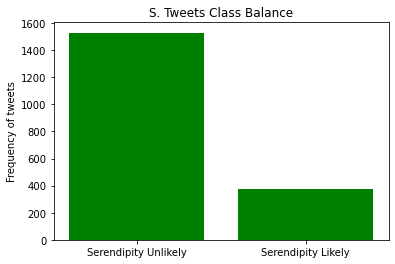

In [12]:
s = [(tweet_data['Prefer'] == 0).sum(),(tweet_data['Prefer'] == 1).sum()]

x_pos = ['Serendipity Unlikely', 'Serendipity Likely']

plt.bar(x_pos, s, color='green')
plt.ylabel("Frequency of tweets")
plt.title("S. Tweets Class Balance")

plt.show()

In [6]:
s[1] / (s[0] + s[1])

0.19568648079957918

In total we have 19.5% of values as the positive class. We will need to correct for class imbalance. 

## 2. Word Clouds of each class

In [7]:
!pip install wordcloud

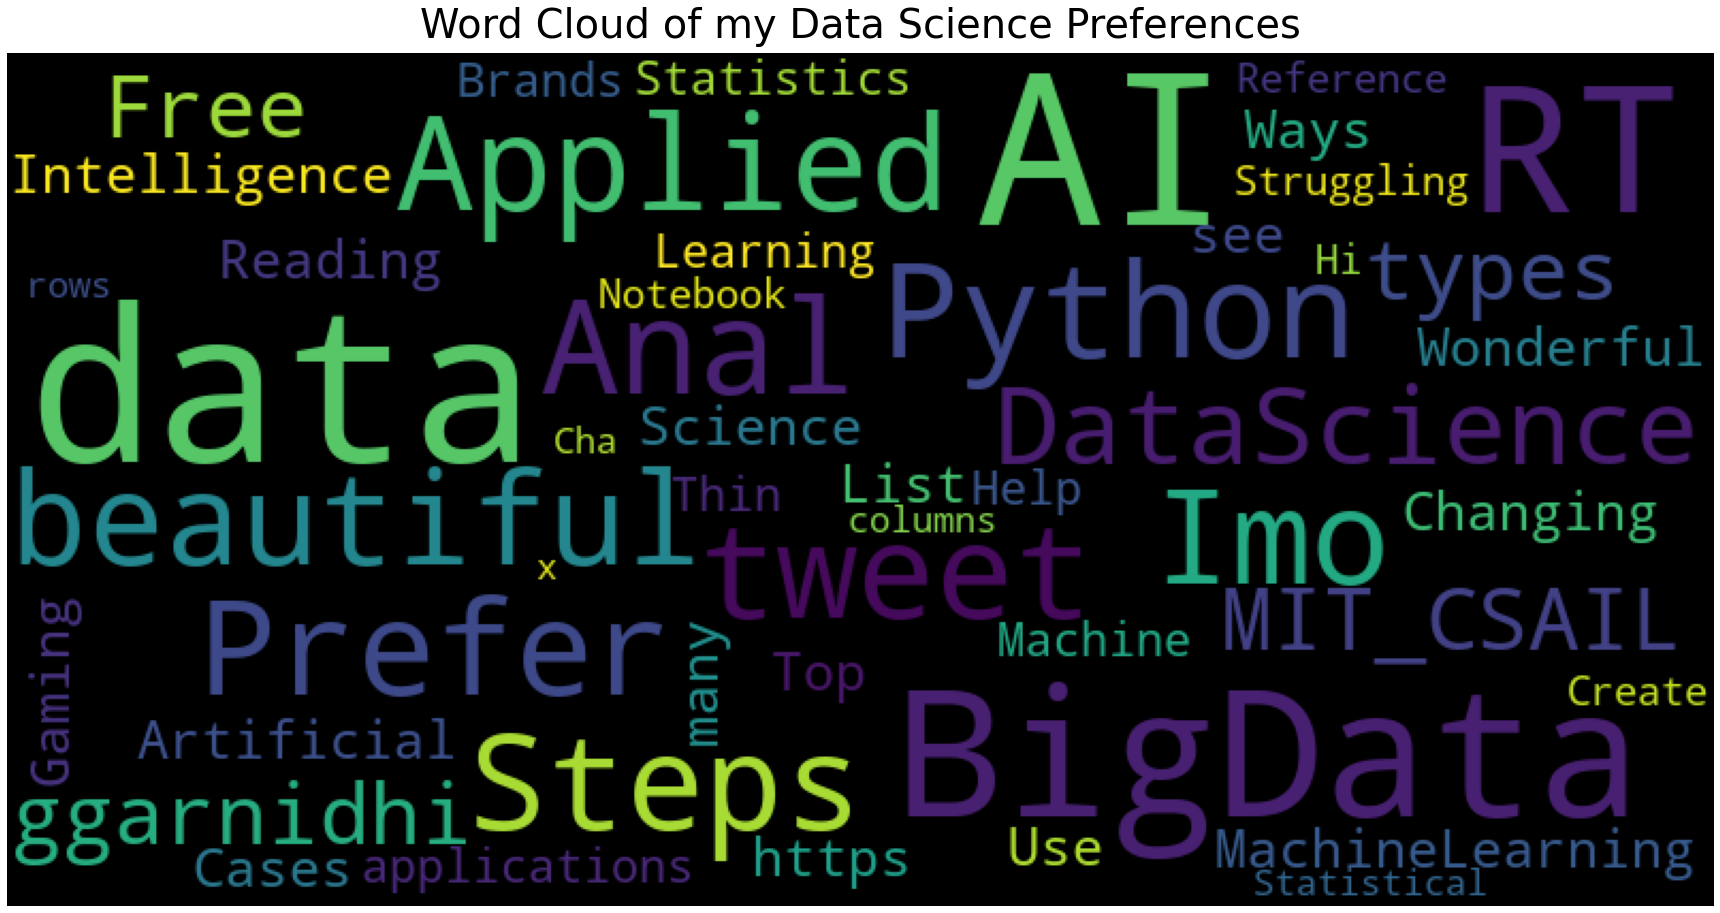

In [11]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(tweet_data[tweet_data["Prefer"]==1], title="Word Cloud of my Data Science Preferences")

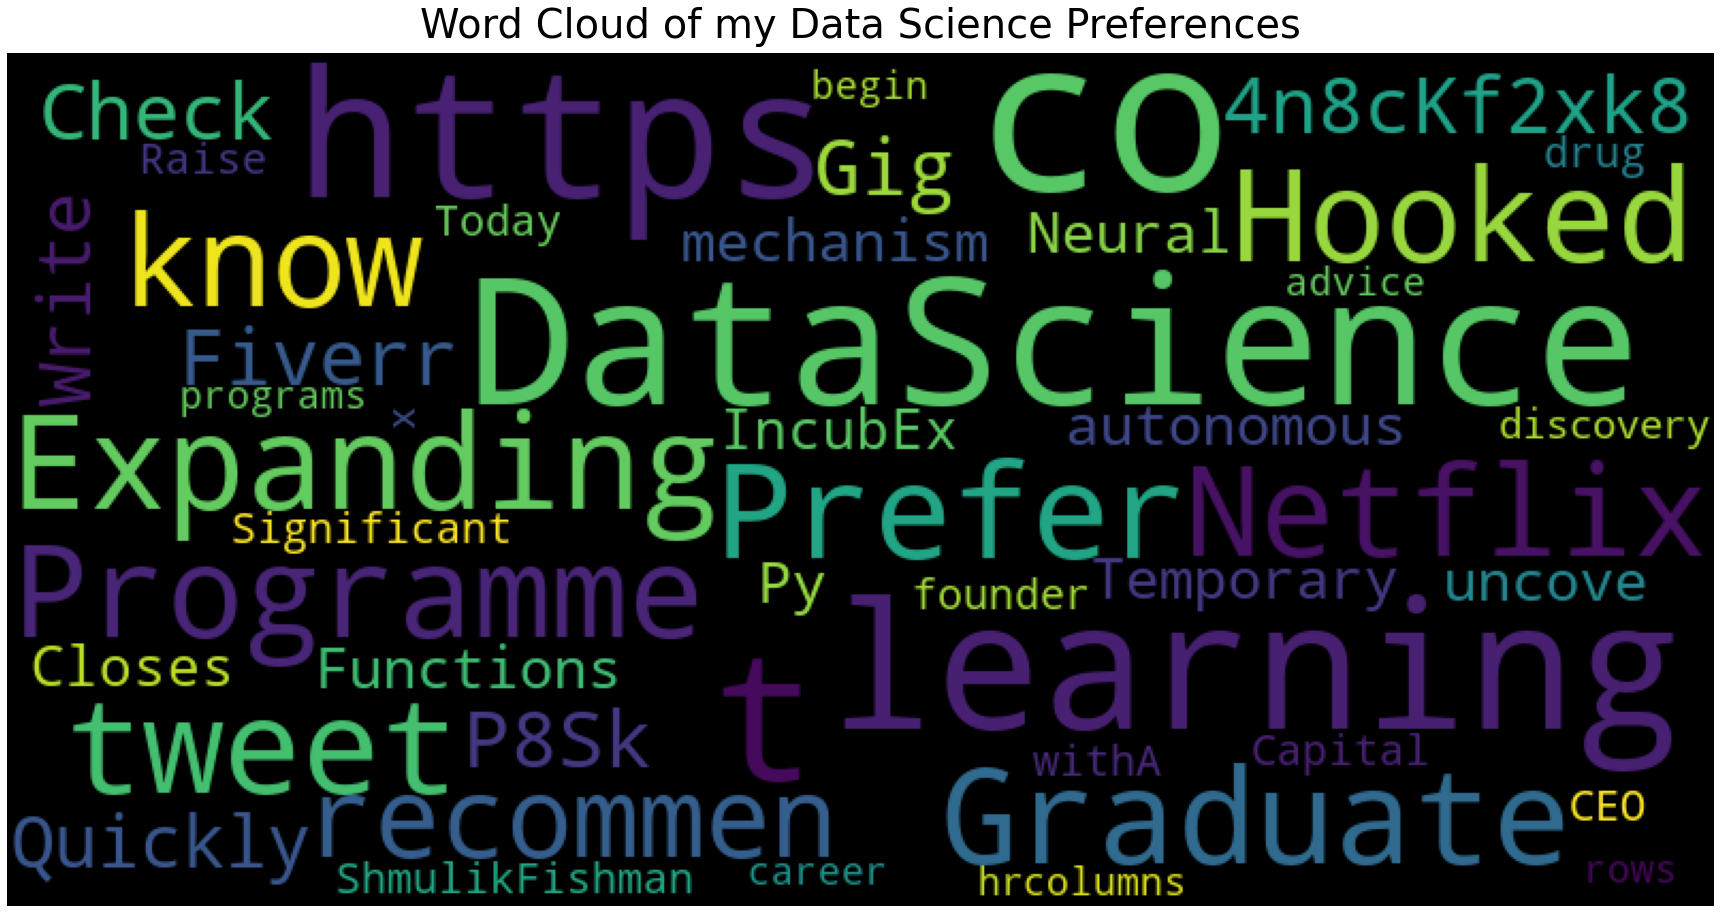

In [12]:
plot_wordcloud(tweet_data[tweet_data["Prefer"]==0], title="Word Cloud of my Data Science Preferences")

Note pattern of 'applied theme': Applied AI, Cases, Applications, beautiful. Makes sense since I've spent time learning theory, now revving to practice more!

## 3. Vanilla Model

In [17]:
from sklearn.model_selection import train_test_split

# Divide into train test
y = tweet_data['Prefer']
X = tweet_data['tweet']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 40,
                                                   stratify = y) 

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train) 
X_test_transformed = bagofwords.transform(X_test) 

X_train_transformed.shape

(1273, 6964)

In [20]:
from sklearn.linear_model import LogisticRegression

# Fitting a model
logreg0 = LogisticRegression(C = 0.1)
logreg0.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg0.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg0.score(X_test_transformed, y_test)}")

Train score: 0.8366064414768264
Test score: 0.7977707006369427


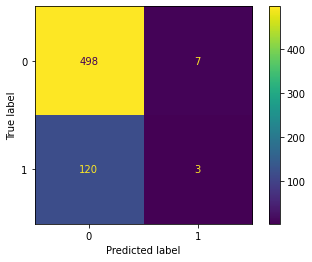

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = logreg0.predict(X_test_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       505
           1       0.30      0.02      0.05       123

    accuracy                           0.80       628
   macro avg       0.55      0.51      0.47       628
weighted avg       0.71      0.80      0.72       628



Accuracy score is high, but recall is really low! Of 123 preferred tweets only guessed 3 correctly. (2% recall) Without a substantially higher recall our model is useless.

## 4. Let us correct for class imbalance & retry

In [23]:
X_train = pd.DataFrame(X_train)

## Class imbalance correction
# Let us try via upsampling
from sklearn.utils import resample

# Upsample
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 0], y_upsampled))

X_train_bal = pd.DataFrame(X_train_bal)

Number of class 1 examples before: 249
Number of class 1 examples after: 1024


In [24]:
# We vectorize
bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train_bal[0])

X_train_transformed = bagofwords.transform(X_train_bal[0]) 
X_test_transformed = bagofwords.transform(X_test) 

In [25]:
# Fitting a model
logreg0 = LogisticRegression(C = 0.1)
logreg0.fit(X_train_transformed, y_train_bal)

# Training and test score
print(f"Train score: {logreg0.score(X_train_transformed, y_train_bal)}")
print(f"Test score: {logreg0.score(X_test_transformed, y_test)}")

Train score: 0.9619140625
Test score: 0.7738853503184714


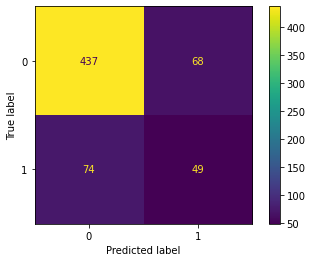

In [26]:
# Get class predictions
y_pred = logreg0.predict(X_test_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [27]:
report_upsampled = classification_report(y_test, y_pred)

print(report_upsampled)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       505
           1       0.42      0.40      0.41       123

    accuracy                           0.77       628
   macro avg       0.64      0.63      0.63       628
weighted avg       0.77      0.77      0.77       628



With upsampling, our recall score went from 2% -> 40%! Substantial! Further, our precision score also jumped from 30% to 42%. This is starting to become a usable model now.

## 5. Let us try a custom tokenizer 

In [28]:
import string
import nltk

# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

# Instantiate
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ammarkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train score: 0.955078125
Test score: 0.7659235668789809


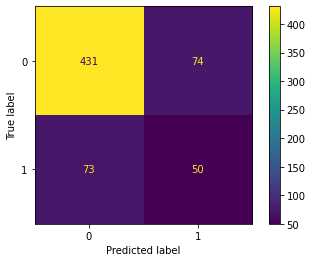

In [29]:
# We vectorize
bagofwords = CountVectorizer(stop_words="english",
                            tokenizer=my_tokenizer)
bagofwords.fit(X_train_bal[0])

X_train_transformed = bagofwords.transform(X_train_bal[0]) 
X_test_transformed = bagofwords.transform(X_test) 

# Fitting a model
logreg0 = LogisticRegression(C = 0.1)
logreg0.fit(X_train_transformed, y_train_bal)

# Training and test score
print(f"Train score: {logreg0.score(X_train_transformed, y_train_bal)}")
print(f"Test score: {logreg0.score(X_test_transformed, y_test)}")


# Get class predictions
y_pred = logreg0.predict(X_test_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [30]:
report_upsampled = classification_report(y_test, y_pred)

print(report_upsampled)

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       505
           1       0.40      0.41      0.40       123

    accuracy                           0.77       628
   macro avg       0.63      0.63      0.63       628
weighted avg       0.77      0.77      0.77       628



An increase in recall from 40% to 41%. Precision drops by 2%. However, this is tolerable since if I get recommended a wrong tweet it takes me 2sec to skim through it. But missing a serendipity is expensive.

## 5. We try TD-IDF vectorization

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

Train score: 0.89501953125
Test score: 0.7213375796178344


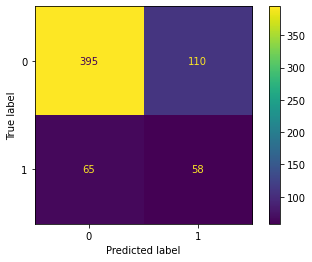

In [32]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words="english",
                            tokenizer=my_tokenizer
                       )
tfidf.fit(X_train_bal[0])

X_train_transformed = tfidf.transform(X_train_bal[0]) 
X_test_transformed = tfidf.transform(X_test) 

# Fitting a model
logreg0 = LogisticRegression(C = 0.1)
logreg0.fit(X_train_transformed, y_train_bal)

# Training and test score
print(f"Train score: {logreg0.score(X_train_transformed, y_train_bal)}")
print(f"Test score: {logreg0.score(X_test_transformed, y_test)}")


# Get class predictions
y_pred = logreg0.predict(X_test_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [33]:
report_upsampled = classification_report(y_test, y_pred)

print(report_upsampled)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       505
           1       0.35      0.47      0.40       123

    accuracy                           0.72       628
   macro avg       0.60      0.63      0.61       628
weighted avg       0.76      0.72      0.74       628



This ratio of recall & precision is the best we've had so far. (And as we'll later find out, the best we get in the entire notebook.)

## 6. Let us try different models

Running takes too long, so pasted snapshots below of previous runs.

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

In [35]:
# Apply TF-IDF vectorization
# TF-IDF
tfidf = TfidfVectorizer(stop_words="english",
                            tokenizer=my_tokenizer
                       )
tfidf.fit(X_train_bal[0])

X_train_transformed = tfidf.transform(X_train_bal[0]) 
X_test_transformed = tfidf.transform(X_test) 

In [36]:
#Step 1 : Set up the Pipeline with the steps we want
from sklearn.pipeline import Pipeline

estimators = [('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

# Grid searching logistic regression, svm, naive bayes, decision trees.
from sklearn.model_selection import GridSearchCV

# solver='liblinear'

param_grid = [{'model': [LogisticRegression()],
              'model__penalty': ['l1','l2'],
              'model__C': list(np.logspace(-5,5,11))},
              
              {'model': [DecisionTreeClassifier()],
              'model__max_depth': list(range(1,int(np.sqrt(X_train.shape[0])))),
              'model__min_samples_leaf': [1,2,3,4,5,6]
              },
              
             {'model': [SVC(kernel='rbf')],
              'model__C': list(np.logspace(-5,5,11))
              },
              
              {'model': [BernoulliNB()]
              }
             ]


grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='recall')

In [37]:
fitted_grid = grid.fit(X_train_transformed,y_train_bal)

Fitting 5 folds for each of 238 candidates, totalling 1190 fits


In [38]:
fitted_grid.best_params_

{'model': DecisionTreeClassifier(max_depth=34),
 'model__max_depth': 34,
 'model__min_samples_leaf': 1}

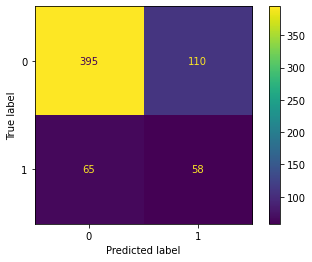

In [39]:
# Get class predictions
y_pred = fitted_grid.predict(X_test_transformed)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [40]:
report_upsampled = classification_report(y_test, y_pred)

print(report_upsampled)

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       505
           1       0.28      0.43      0.34       123

    accuracy                           0.67       628
   macro avg       0.56      0.58      0.56       628
weighted avg       0.73      0.67      0.69       628



Recall & precision both lesser than classic log reg with c=10 & l1 regularization. We will stick to it for our model.

## 7. We double down on logistic regression

Running taking too long, snapshot of previous run pasted below. Main insight: Classic Log Reg with l1 regularization & c=10 still gives a better recall & precision.

In [ ]:
# Log reg best, so let's double down here.
#Logistic Regression grid search
estimators = [('model', LogisticRegression(max_iter = 300))]
pipe = Pipeline(estimators)
param_grid = [
        {#l1
            'model__penalty':['l1'],
            'model__solver' :['liblinear'],
            'model__C': np.logspace(-3,3,7)
        },
        {#l2
            'model__penalty':['l2'],
            'model__solver' :['liblinear','lbfgs','saga'],
            'model__C': np.logspace(-3,3,7)

        },
        {#elasticnet
            'model__penalty':['elasticnet'],
            'model__l1_ratio':np.arange(0.2,0.8,0.1),
            'model__solver' :['saga'],
            'model__C': np.logspace(-3,3,7)
        },
        {#No penalty
            'model__penalty':['none'],
            'model__solver' :['lbfgs']}
    ]


log_reg_grid_recall = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1,
    scoring = 'recall')

log_reg_grid_recall.fit(X_train_transformed, y_train_bal)

In [ ]:
# Get class predictions
y_pred = log_reg_grid_recall.predict(X_test_transformed)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [ ]:
report_upsampled = classification_report(y_test, y_pred)

print(report_upsampled)

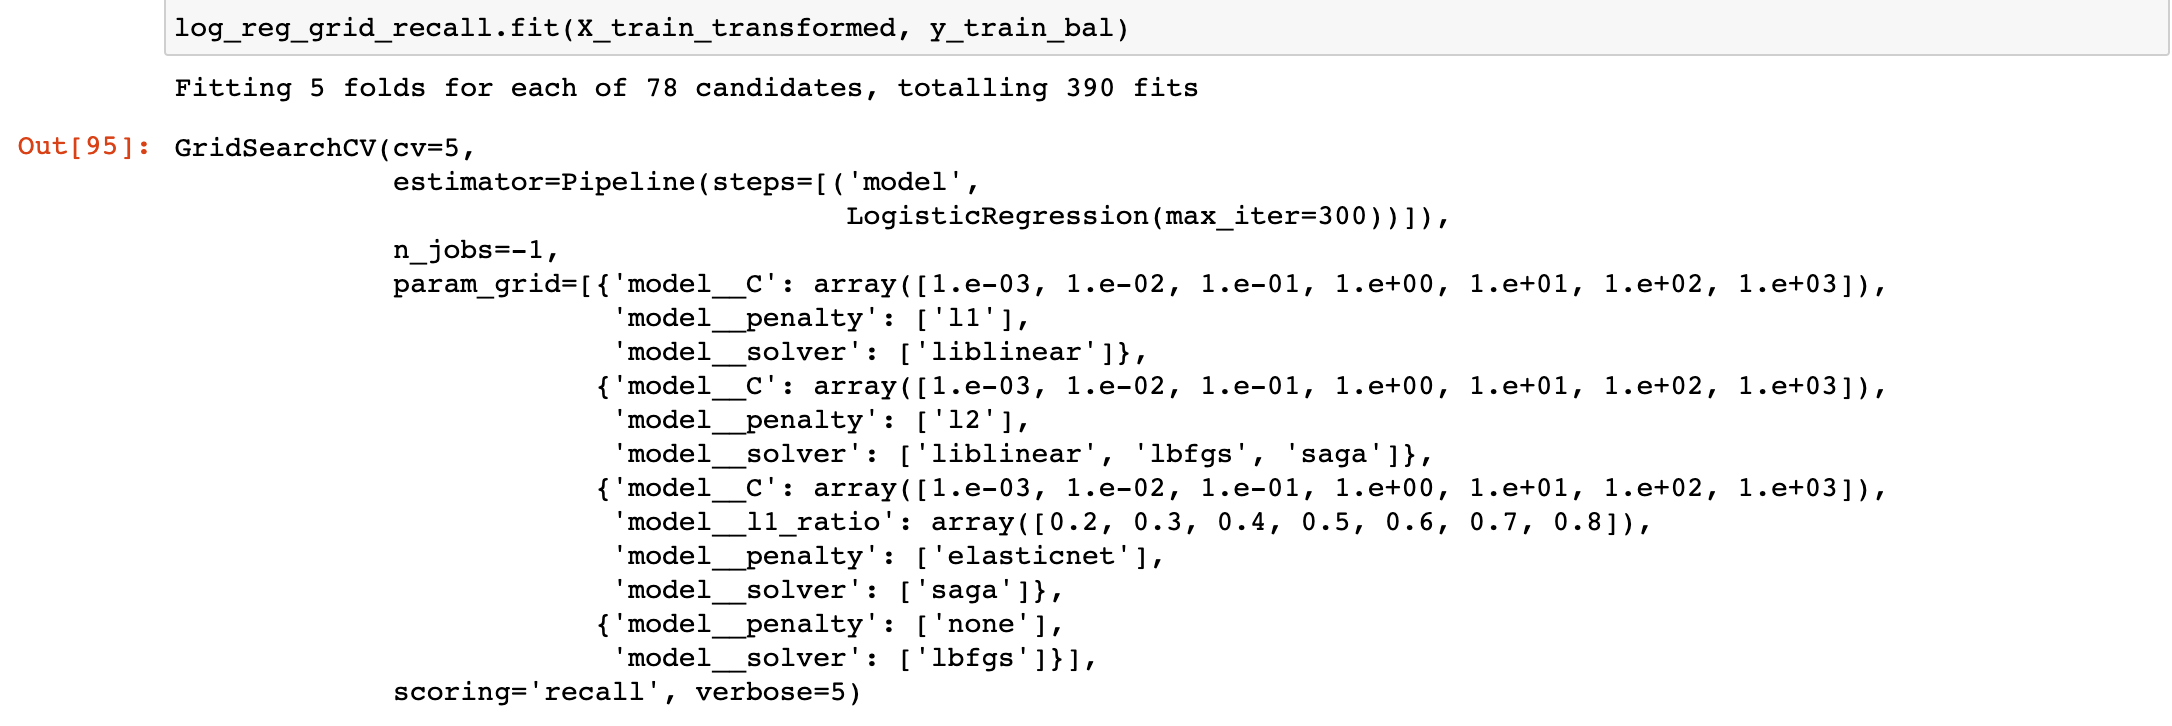

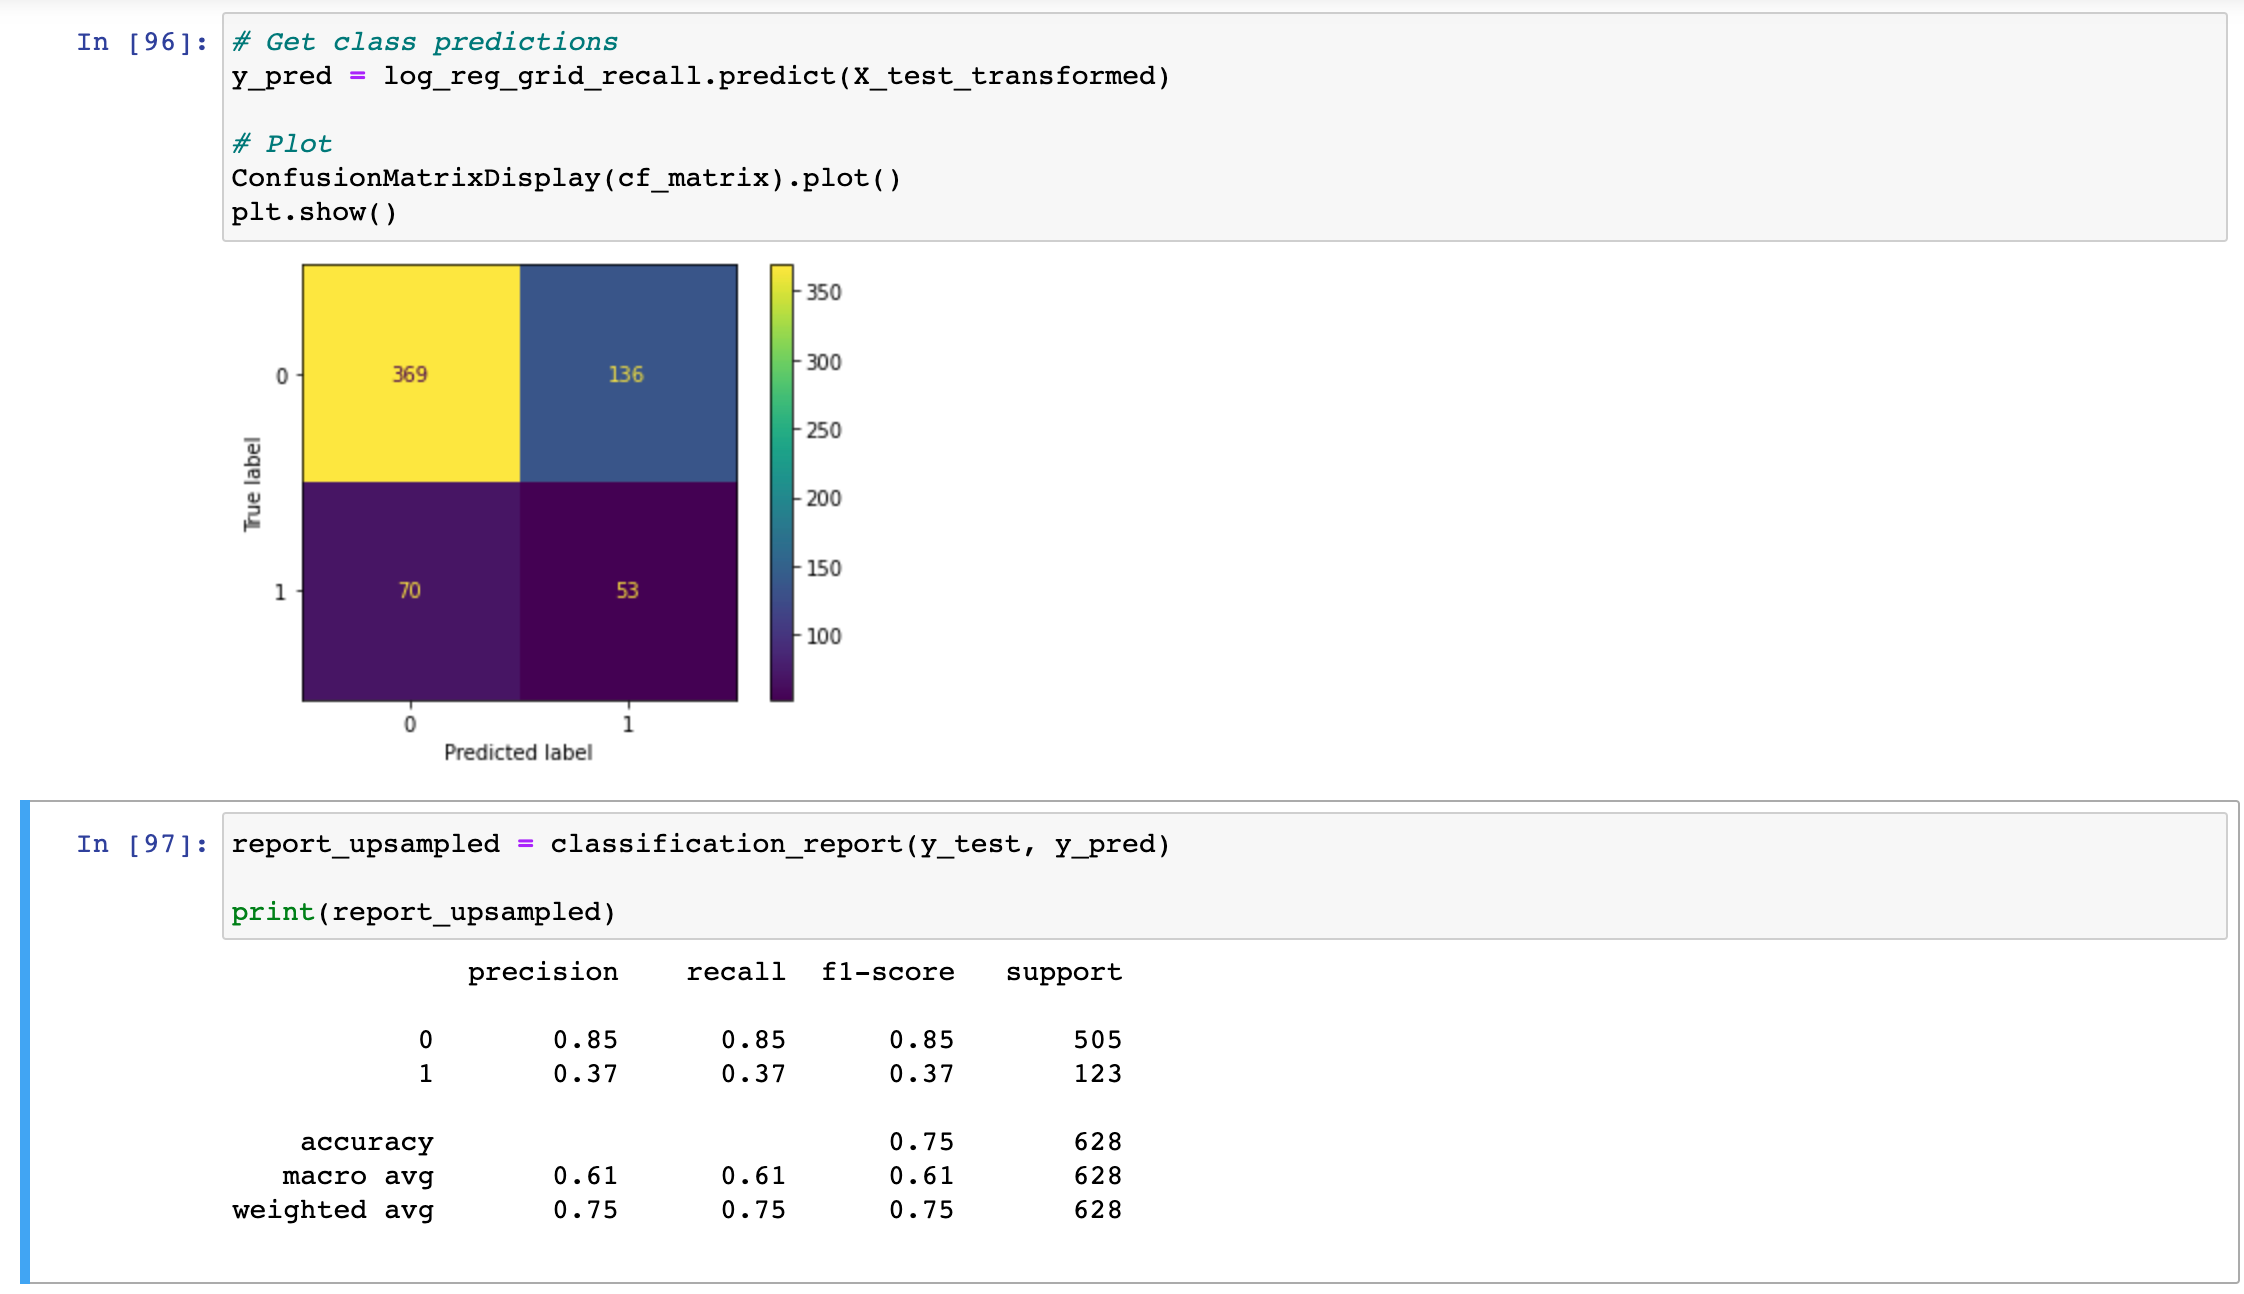